## Music Analysis

### An analysis of music for my pilates classes

Why... How...

I believe that the good song for the practice is the one I do not hear, or pay attention to. It gives the mood, the rhythm, the flow. But my brain should not catch it. The song should be around, not whithin.

— January 2016 —

### Summary

#### Preliminaries

I use pandas and matplotlib...

In [364]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

# set seaborn plot defaults
import seaborn as sns; seaborn.set()

# format floating point numbers
pd.set_option('float_format', '{:.2f}'.format)

The hero and the foundation of my analysis is the Echo Nest library. 

In [365]:
from pyechonest import config
config.ECHO_NEST_API_KEY="1RNDIJ5SITBKZFDCT"

I made a list of hand picked songs that match the rhythm of my classes. I use this list as...  
I saved the data as a sqlite dictionary and use the sqlitedict library to access it.

In [91]:
from sqlitedict import SqliteDict
db = SqliteDict('./chosen_tracks', autocommit=True)

In [397]:
# remove
csv_file = 'Yoga Music  - Sheet1.csv'

def add_songs_from_csv(csv_file, db):
    data = pd.read_csv(csv_file, index_col='Song', encoding='utf_8', header=0)
    for item in data.index:
        artist = data.loc[item]['Artist']
        song_cat = data.loc[item]['Category']
        if not db.get(item):
            db[item] = {'artist' : artist, 'category' : song_cat}
    print len(db)
add_songs_from_csv(csv_file, db)

128


In [92]:
# remove
""" Add a new song by hand to the db
"""
db['Any Other Name'] = {'artist' : 'Thomas Newman', 'category' : 'yoga'}

Using the Echo Nest library is super easy and straighforward.

In [371]:
def get_song_data(artist_name, song_title):
    from pyechonest import song
    """ The library has limitations and 
    doesn't provide data for every artist or song.
    I gracefully handle missing items with a 
    "try-except" block.
    """
    try: 
        result = song.search(artist=artist_name, 
                             title=song_title)
        song_result = result[0]
        song_data = song_result.audio_summary
        return song_data
    
    except IndexError as e:
        print 'No data for the song', song_title
        return None
    
def add_song_data_to_db(song_title, song_data, db):
    """ Add song data we get from Echo Nest 
    to the DB.
    """
    song_val = {'time_signature' : song_data['time_signature'],
                'energy' : song_data['energy'],
                'tempo' : song_data['tempo'], 
                'speechiness' : song_data['speechiness'],
                'acousticness' : song_data['acousticness'], 
                'danceability' : song_data['danceability'],
                'instrumentalness' : song_data['instrumentalness'],
                'key' : song_data['key'],
                'loudness' : song_data['loudness'],
                'valence' : song_data['valence'],
                'mode' : song_data['mode']}
    value = db[song_title]
    value.update(song_val)
    db[song_title] = value
    print 'Saved', song_title, db[song_title]
            
def check_data_in_db(db):
    """ Look for new songs in the DB and get 
    song attributes from the Echo Nest library.
    """
    for song_title, value in db.iteritems():
        # Check if the attributes have been added
        if value.get('tempo') or value.get('No_data'): 
            pass
        else:
            song_data = get_song_data(value['artist'], 
                                      song_title)
            # If the song is in the Echo Nest base, 
            # I add the data to the DB.
            if song_data:
                add_song_data_to_db(song_title, 
                                    song_data, db)
            # If not, I add 'No_data' tag for the song. 
            else:
                song_val = {'No_data' : True}
                value.update(song_val)
                db[song_title] = value

In [398]:
# call the function
check_data_in_db(db)

No data for the song Wear your seat belt


In [391]:
# remove
""" Count the number of 'good' 
songs in the DB. 
"""
count = 0
for k, v in db.iteritems():
    if v.get('tempo'):
        count += 1
    else: continue
print count

91


### Data overview  
  
Next we read in data from the database and take a look at what we're working with.

In [529]:
def read_db_in_pandas(db):
    """ Read the DB."""
    # Transpose data to have keys as index.
    df = pd.DataFrame(dict(db)).T

    # Remove rows with no data for a song.
    df_clean = df[df['No_data'] != 1]

    # Convert columns into numbers.
    df_clean = df_clean.convert_objects(convert_numeric=True)
    
    # Remove the 'No_data' column. 
    df_clean = df_clean.drop('No_data', 1)
    return df_clean

df = read_db_in_pandas(db)

In [530]:
print ("There are {0} items in the dataset."
       .format(len(db)))
print ("{0} items have no data available."
       .format(len(db) - len(df)))
print ("We are left with {0} songs to use as a base model."
       .format(len(df)))
print "\nBelow is a random sample of the dataset."
df.sample(n=4)

There are 128 items in the dataset.
37 items have no data available.
We are left with 91 songs to use as a base model.

Below is a random sample of the dataset.


,acousticness,artist,category,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
Too Much time together,0.26,San Cisco,cycling,0.56,0.84,0.00,2,-5.35,1,0.05,154.88,4,0.96
Bittersweet (Part 2 - Gat),0.85,Stevin McNamara,yoga,0.85,0.22,0.92,7,-17.54,1,0.05,114.05,4,0.12
Ladder Of Lights,0.74,Cypher 7,focus,0.62,0.21,0.91,5,-22.58,0,0.03,128.97,3,0.17
Lounge Me,0.01,Sunsphere,focus,0.68,0.64,0.89,10,-11.41,0,0.05,97.97,4,0.54


The dataset contains songs in three categories: yoga, focus, and cycling. 
Let's examine songs labeled with 'yoga', which I use both for my pilates and yoga practices. 

In [494]:
df_yoga = df[df['category'] == 'yoga']
yoga_descr = df_yoga.describe()
yoga_descr

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
count,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00,31.00
mean,0.84,0.44,0.19,0.81,5.84,-19.55,0.68,0.04,110.50,3.39,0.23
std,0.22,0.19,0.14,0.25,2.97,5.85,0.48,0.01,27.25,1.05,0.21
min,0.19,0.06,0.01,0.00,0.00,-35.78,0.00,0.03,57.83,1.00,0.03
25%,0.84,0.36,0.10,0.83,3.00,-21.37,0.00,0.04,94.06,3.00,0.07
50%,0.91,0.41,0.19,0.90,6.00,-18.39,1.00,0.04,110.64,4.00,0.15
75%,0.98,0.57,0.26,0.94,8.50,-15.60,1.00,0.05,130.26,4.00,0.34
max,0.99,0.85,0.56,0.98,10.00,-11.17,1.00,0.10,175.70,5.00,0.81


These data might speak for themselves for an ace musician but I've no idea how to assess the level of the tempo or valence here. Is it high? Low? How different is it? To make it clearer I'll compare these data to another sample that contains more energetic music for cycling. 

In [495]:
# make a DF for a 'cycling' label
df_cycling = df[df['category'] == 'cycling']
# basic statistical calculations
cycling_descr = df_cycling.describe()
# concatenate into one table for the convenience
result = pd.concat([yoga_descr, cycling_descr], 
                   keys=['yoga', 'cycling'], 
                   names=['category', 'measures'])
# sort the table to make it more readable
result.sortlevel(level=1).reorder_levels(['measures', 'category'])

acousticness  danceability  energy  instrumentalness   key  \
measures category                                                               
count    yoga             31.00         31.00   31.00             31.00 31.00   
         cycling          26.00         26.00   26.00             26.00 26.00   
mean     yoga              0.84          0.44    0.19              0.81  5.84   
         cycling           0.11          0.60    0.79              0.08  5.58   
std      yoga              0.22          0.19    0.14              0.25  2.97   
         cycling           0.22          0.14    0.14              0.19  4.06   
min      yoga              0.19          0.06    0.01              0.00  0.00   
         cycling           0.00          0.39    0.44              0.00  0.00   
25%      yoga              0.84          0.36    0.10              0.83  3.00   
         cycling           0.00          0.48    0.67              0.00  1.25   
50%      yoga              0.91          0.41    0.19              0.90  6.00   
         cycling           0.02          0.60    0.83              0.00  6.50   
75%      yoga              0.98          0.57    0.26              0.94  8.50   
         cycling           0.09          0.67    0.90              0.05  9.00   
max      yoga              0.99          0.85    0.56              0.98 10.00   
         cycling           0.95          0.95    0.98              0.86 11.00   

                   loudness  mode  speechiness  tempo  time_signature  valence  
measures category                                                               
count    yoga         31.00 31.00        31.00  31.00           31.00    31.00  
         cycling      26.00 26.00        26.00  26.00           26.00    26.00  
mean     yoga        -19.55  0.68         0.04 110.50            3.39     0.23  
         cycling      -5.97  0.77         0.06 136.66            4.00     0.70  
std      yoga          5.85  0.48         0.01  27.25            1.05     0.21  
         cycling       2.51  0.43         0.03  22.40            0.00     0.21  
min      yoga        -35.78  0.00         0.03  57.83            1.00     0.03  
         cycling     -13.79  0.00         0.03  86.01            4.00     0.26  
25%      yoga        -21.37  0.00         0.04  94.06            3.00     0.07  
         cycling      -6.81  1.00         0.04 122.24            4.00     0.58  
50%      yoga        -18.39  1.00         0.04 110.64            4.00     0.15  
         cycling      -5.33  1.00         0.05 133.00            4.00     0.74  
75%      yoga        -15.60  1.00         0.05 130.26            4.00     0.34  
         cycling      -4.82  1.00         0.06 146.96            4.00     0.88  
max      yoga        -11.17  1.00         0.10 175.70            5.00     0.81  
         cycling      -1.84  1.00         0.17 190.04            4.00     0.97

This table gives...
Next step is to visualize the data.

First I create a new column in the DF where I'll label each song with a number. There is a special function in sklearn for this operation - LabelBinarizer() - but I'll go with this solution.

In [531]:
def label_categories(row):
    # make a list of categories
    categories = list(pd.unique(df.category.ravel()))
    for item in categories:
        if row['category'] == item:
            return categories.index(item) 
        
df['num_cat'] = df.apply (lambda row: label_categories(row), axis=1)

Let's plot the data.

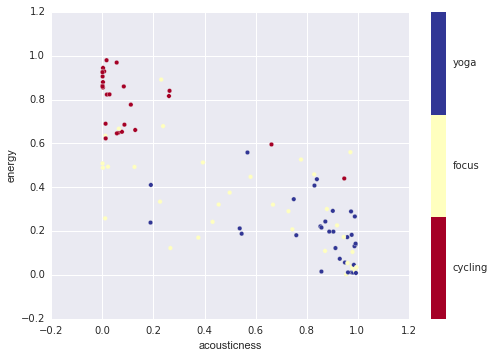

In [532]:
# list columns with numeric values
cols = df.select_dtypes(exclude=[object]).columns

# the formatter will label the colorbar with categories
formatter = plt.FuncFormatter(lambda i, 
                               *args: df.category[int(i)])

"""I can change index to see the relationship
between different variables. 
"""
x_index = 0
y_index = 2

# make a plot
plt.scatter(df[cols[x_index]], df[cols[y_index]],
            c=df.num_cat, cmap=plt.cm.get_cmap('RdYlBu', 3))
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.clim(-0.5, 2.5)
plt.xlabel(cols[x_index])
plt.ylabel(cols[y_index]);

Ironically, the 'focus' category is the least focused. 

Before I start working with scikit-learn library, I need to rearrange the dataset a bit.

In [535]:
# keep values only in numerical form
df_matrix = df[cols]

# move the label column to the left-most column
cols_list = df_matrix.columns.tolist()
cols_list = [cols_list[-1]] + cols_list[0:-1]
df_matrix = df_matrix[cols_list]

# review of the dataset
df_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 1957 to they move on tracks of never-ending light
Data columns (total 12 columns):
num_cat             91 non-null int64
acousticness        91 non-null float64
danceability        91 non-null float64
energy              91 non-null float64
instrumentalness    91 non-null float64
key                 91 non-null int64
loudness            91 non-null float64
mode                91 non-null int64
speechiness         91 non-null float64
tempo               91 non-null float64
time_signature      91 non-null int64
valence             91 non-null float64
dtypes: float64(8), int64(4)
memory usage: 9.2+ KB


Finally, we convert the processed training data from a Pandas dataframe into a numerical (Numpy) array.

In [537]:
train_data = df_matrix.values

Here we'll be using the Random Forest model.

In [538]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100)

We use the processed training data to 'train' (or 'fit') our model. The column num_cat will be our second input, and the set of other features as the first.

In [540]:
model = model.fit(train_data[0:,1:], train_data[0:,0])

#### Making predictions
We first load the test data.

In [576]:
# read xml with itunes music
xml_file = 'itunes_library.xml'


In [ ]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(open(xml_file), 'xml')

In [577]:
import xml.etree.ElementTree as etree
tree = etree.parse(xml_file)
root = tree.getroot()


<Element 'dict' at 0x11527d690>


In [586]:
els = [element for element in tree.findall('.//dict')]

In [590]:
e = els[0]
e.

In [499]:
from sklearn_pandas import DataFrameMapper
import numpy as np
import sklearn.preprocessing, sklearn.decomposition, \
sklearn.linear_model, sklearn.pipeline, sklearn.metrics

In [500]:
mapper = DataFrameMapper([
        ('num_cat', None),
        ([u'acousticness', u'danceability', 
          u'energy', u'instrumentalness', 
          u'key', u'loudness', u'mode', 
          u'speechiness', u'tempo', 
          u'time_signature', u'valence'], sklearn.preprocessing.StandardScaler())
        ])

This is the sample of the data after the performed transformations.

In [501]:
df_matrix = np.round(mapper.fit_transform(df.copy()), 2)
df_matrix[:2]

array([[ 0.  ,  0.34, -0.25,  0.6 , -1.57, -1.38,  0.71,  0.72, -0.79,
         2.2 ,  0.36,  0.73],
       [ 1.  ,  0.63, -1.24,  0.37,  0.91,  1.17, -0.38, -1.39,  1.47,
        -0.1 ,  0.36, -1.05]])

In [502]:
# The shape of the resulting matrix
n_samples, n_features = df_matrix.shape
print ("We have {0} rows and {1} columns in the matrix."
       .format(n_samples, n_features))

We have 91 rows and 12 columns in the matrix.


<function view>

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X, y = iris.data, iris.target

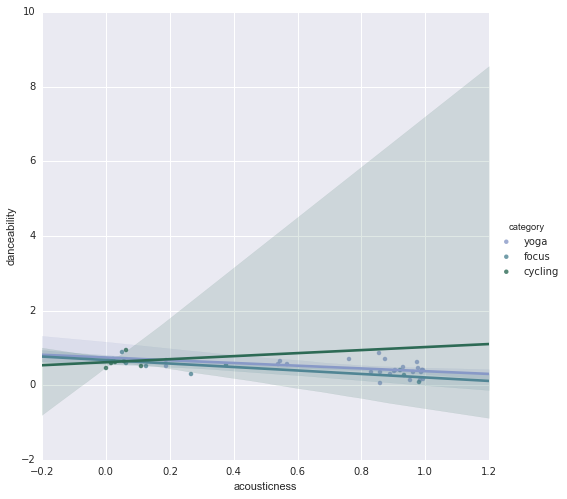

In [332]:
# Make a custom sequential palette using the cubehelix system
# pal = sns.cubehelix_palette(4, 1.5, .75, light=.6, dark=.2)

# # Plot tip as a function of toal bill across days
# g = sns.lmplot(x="acousticness", y="danceability", hue="category", data=df,
#                palette=pal, size=7)